In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
df = pd.read_csv("Mastercard_stock_history.csv", index_col = "Date", parse_dates = ["Date"], dayfirst=True)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000,0.0,0
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000,0.0,0
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000,0.0,0
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000,0.0,0
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000,0.0,0


In [48]:
df.drop(["Dividends","Stock Splits"], axis=1, inplace=True)
df

,Open,High,Low,Close,Volume
Date,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000
...,...,...,...,...,...
2021-10-05,347.121403,348.130138,342.497240,342.776886,4724100
2021-10-06,339.580960,348.439763,338.682072,348.250000,3712000
2021-10-07,349.000000,357.899994,349.000000,353.910004,3209200


In [49]:
df.describe()

,Open,High,Low,Close,Volume
count,3872.000000,3872.000000,3872.000000,3872.000000,3.872000e+03
mean,104.896814,105.956054,103.769349,104.882714,1.232250e+07
std,106.245511,107.303589,105.050064,106.168693,1.759665e+07
min,3.748967,4.102467,3.739664,4.083861,6.411000e+05
25%,22.347203,22.637997,22.034458,22.300391,3.529475e+06
50%,70.810079,71.375896,70.224002,70.856083,5.891750e+06
75%,147.688448,148.645373,146.822013,147.688438,1.319775e+07
max,392.653890,400.521479,389.747812,394.685730,3.953430e+08


In [50]:
df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [51]:
#### can not randomly devide the dataset

In [52]:
pred_col = "High"
stock_prices = df[pred_col]

In [53]:
def train_test_plot(tstart, tend):
    plt.figure(figsize=(16,4))
    sns.lineplot(stock_prices[f"{tstart}" : f"{tend}"])
    sns.lineplot(stock_prices[f"{tend + 1}" : ])
    plt.legend([f"Train (Before {tend})", f"Test ({tend} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

In [54]:
tstart = 2016
tend = 2020

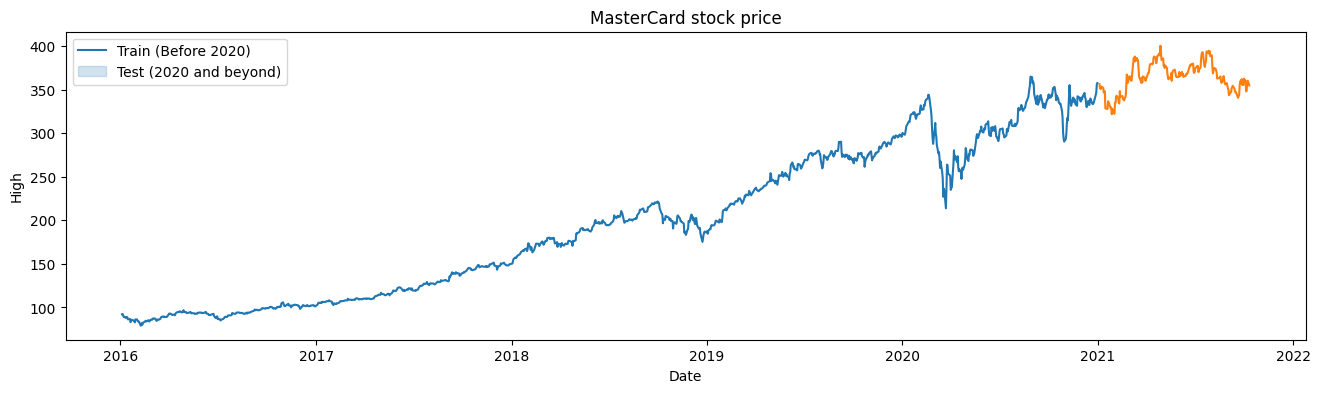

In [55]:
train_test_plot(tstart, tend)

In [56]:
def train_test_split(tstart, tend):
    train = stock_prices.loc[f"{tstart}":f"{tend}"].values
    test = stock_prices.loc[f"{tend+1}":].values
    return train, test

In [57]:
n_steps = 60
training_set, test_set = train_test_split(tstart, tend)
input_set = stock_prices[df.shape[0] - test_set.shape[0] - n_steps : ].values

In [58]:
training_set.shape, test_set.shape, input_set.shape

((1259,), (195,), (255,))

In [59]:
from sklearn.preprocessing import MinMaxScaler

In [63]:
sc = MinMaxScaler(feature_range = (0,1))
sc.fit(np.expand_dims(np.concatenate((training_set, input_set)), axis=1))

training_set = sc.transform(np.expand_dims(training_set, axis=1))
input_set = sc.transform(np.expand_dims(input_set, axis=1))

In [64]:
def split_sequence(sequence):
    X, y = list(), list()
    for i in range(len(sequence) - n_steps):
        X.append(sequence[i : i + n_steps])
        y.append(sequence[i + n_steps])
    return np.array(X), np.array(y)

In [65]:
X_train, y_train = split_sequence(training_set)
X_input, y_true = split_sequence(input_set)

In [69]:
X_train.shape, y_train.shape, X_input.shape, y_true.shape 

((1199, 60, 1), (1199, 1), (195, 60, 1), (195, 1))

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, GRU

In [71]:
model_lstm = Sequential()
model_lstm.add(Bidirectional(GRU(units = 128, return_sequences = True, activation = "tanh", input_shape = (n_steps, 1))))
model_lstm.add(Bidirectional(GRU(units = 128)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer = "RMSprop", loss = "mse")

In [72]:
model_lstm.fit(X_train, y_train, epochs = 25, batch_size = 32, verbose=1)

Epoch 1/25


2023-06-16 04:15:39.073978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 04:15:39.075957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 04:15:39.077446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - 11s 149ms/step - loss: 0.0131
Epoch 2/25
38/38 [==============================] - 5s 140ms/step - loss: 0.0041
Epoch 3/25
38/38 [==============================] - 5s 135ms/step - loss: 0.0025
Epoch 4/25
38/38 [==============================] - 5s 132ms/step - loss: 0.0020
Epoch 5/25
38/38 [==============================] - 5s 132ms/step - loss: 0.0019
Epoch 6/25
38/38 [==============================] - 5s 133ms/step - loss: 0.0015
Epoch 7/25
38/38 [==============================] - 6s 152ms/step - loss: 0.0015
Epoch 8/25
38/38 [==============================] - 6s 144ms/step - loss: 0.0013
Epoch 9/25
38/38 [==============================] - 6s 168ms/step - loss: 0.0014
Epoch 10/25
38/38 [==============================] - 7s 174ms/step - loss: 0.0011
Epoch 11/25
38/38 [==============================] - 6s 163ms/step - loss: 9.3441e-04
Epoch 12/25
38/38 [==============================] - 7s 172ms/step - loss: 8.8644e-04
Epoch 13/25
38/38 [========

In [76]:
predicted_stock_price = sc.inverse_transform(model_lstm.predict(X_input))

2023-06-16 04:19:55.466066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 04:19:55.468256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 04:19:55.469297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 38ms/step


In [77]:
def plot_predictions(test, predicted):
    plt.figure(figsize = (10,5))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()

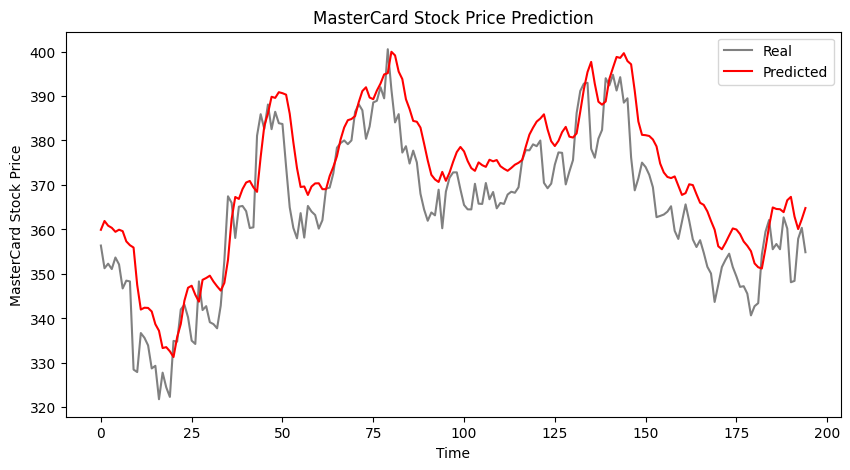

In [80]:
plot_predictions(test_set, predicted_stock_price)

In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [82]:
rmse = mean_squared_error(test_set, predicted_stock_price) ** 0.5
mae = mean_absolute_error(test_set, predicted_stock_price)

print("Absolute error :", mae)
print("Root Mean Squared error :", rmse)

Absolute error : 7.941693811175881
Root Mean Squared error : 9.34993332617607
